# OWL-ViT minimal example

This Colab shows how to **load a pre-trained OWL-ViT checkpoint** and use it to
**get object detection predictions** for an image. 

It is meant as a starting point for developing more complex applications. If you would like to try the model interactively, check out the **OWL-ViT Inference Playground** instead.

TODO: Add inference playground link.

# Download and install OWL-ViT

OWL-ViT is implemented in [Scenic](https://github.com/google-research/scenic). The cell below installs the Scenic codebase from GitHub and imports it.

In [ ]:
!rm -rf *
!rm -rf .config
!rm -rf .git
!git clone https://github.com/google-research/scenic.git .
!python -m pip install -q .
!python -m pip install -r scenic/projects/baselines/clip/requirements.txt

In [12]:
import os

import jax
from matplotlib import pyplot as plt
import numpy as np
from scenic.projects.owl_vit import models
from scenic.projects.owl_vit.configs import clip_b32
from scipy.special import expit as sigmoid
import skimage
from skimage import io as skimage_io
from skimage import transform as skimage_transform

# Choose config

In [5]:
config = clip_b32.get_config()

# Load the model and variables

In [6]:
module = models.TextZeroShotDetectionModule(
    body_configs=config.model.body,
    normalize=config.model.normalize,
    box_bias=config.model.box_bias)

In [8]:
variables = module.load_variables(config.init_from.checkpoint_path)

# Prepare image

In [9]:
# Load example image:
filename = os.path.join(skimage.data_dir, 'astronaut.png')
image_uint8 = skimage_io.imread(filename)
image = image_uint8.astype(np.float32) / 255.0

# Pad to square with gray pixels on bottom and right:
h, w, _ = image.shape
size = max(h, w)
image_padded = np.pad(
    image, ((0, size - h), (0, size - w), (0, 0)), constant_values=0.5)

# Resize to model input size:
input_image = skimage.transform.resize(
    image_padded,
    (config.dataset_configs.input_size, config.dataset_configs.input_size),
    anti_aliasing=True)

# Prepare text queries

In [10]:
text_queries = ['human face', 'space shuttle']
tokenized_queries = np.array([module.tokenize(q) for q in text_queries])

# Get predictions

In [13]:
# Note: The model expects a batch dimension.
predictions = module.apply(
    variables,
    input_image[None, ...],
    tokenized_queries[None, ...],
    train=False)

# Remove batch dimension and convert to numpy:
predictions = jax.tree_map(lambda x: np.array(x[0]), predictions )

# Plot predictions

In [14]:
%matplotlib inline

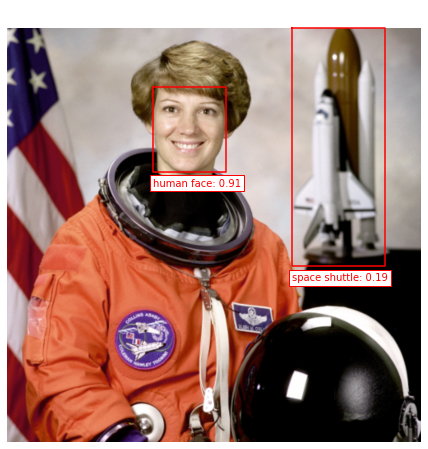

In [16]:
score_threshold = 0.16

scores = sigmoid(np.max(predictions['pred_logits'], axis=-1))
labels = np.argmax(predictions['pred_logits'], axis=-1)
boxes = predictions['pred_boxes']

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(input_image, extent=(0, 1, 1, 0))
ax.set_axis_off()

for score, box, label in zip(scores, boxes, labels):
  if score < score_threshold:
    continue
  cx, cy, w, h = box
  ax.plot([cx - w / 2, cx + w / 2, cx + w / 2, cx - w / 2, cx - w / 2],
          [cy - h / 2, cy - h / 2, cy + h / 2, cy + h / 2, cy - h / 2], 'r')
  ax.text(
      cx - w / 2,
      cy + h / 2 + 0.015,
      f'{text_queries[label]}: {score:1.2f}',
      ha='left',
      va='top',
      color='red',
      bbox={
          'facecolor': 'white',
          'edgecolor': 'red',
          'boxstyle': 'square,pad=.3'
      })